# SI Figure 2, Figure 3 and Table 3

In [1]:
import pyam
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from pathlib import Path
import string
import pandas as pd
import numpy as np
import seaborn as sns
plt.style.use(
    "plotting_template.mplstyle"
)

<IPython.core.display.Javascript object>

# Read in the necessary data

In [2]:
data_folder = Path(
    "..","data"
)

In [3]:
data_file = Path(
    data_folder / "AR6_Scenarios_Snapshot.xlsx"
)

In [4]:
meta_file = Path(
    data_folder / "AR6_Scenarios_Updated_Meta.xlsx"
)

In [5]:
df_ar6 = pyam.IamDataFrame(data_file)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/AR6_Scenarios_Snapshot.xlsx
pyam.core - INFO: Reading meta indicators


In [6]:
df_ar6.load_meta(meta_file)

pyam.core - INFO: Reading meta indicators


# Figure 2
* Panel a: Peak exceedance probability
* Panel b: Difference between peak and end of century warming
* Panel c: Post peak temperature trend

In [7]:
plot_figure_2 = df_ar6.filter(
    Category_rolling_mean=["C1", "C2", "C3"],
    variable =[
        "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile",
        "AR6 climate diagnostics|Exceedance Probability 1.5C|MAGICCv7.5.3",
        "AR6 climate diagnostics|Exceedance Probability 2.0C|MAGICCv7.5.3"
    ]
)

In [8]:
plot_figure_2.unit_mapping

{'AR6 climate diagnostics|Exceedance Probability 1.5C|MAGICCv7.5.3': 'dimensionless',
 'AR6 climate diagnostics|Exceedance Probability 2.0C|MAGICCv7.5.3': 'dimensionless',
 'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile': 'K'}

In [9]:
plot_figure_2.rename(
    variable = {
        "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile": "Temperature"
    },
    inplace = True
)

# Set peak and end of century characteristics.

Peak and end of century warming.

In [10]:
plot_figure_2.set_meta_from_data(
    variable="Temperature",
    method=np.max,
    name="peak_warming"
)

In [11]:
plot_figure_2.set_meta_from_data(
    variable="Temperature",
    year=2100,
    name="2100_warming"
)

Now, we need to identify the year of peak warming.

In [12]:
temp = plot_figure_2.filter(
    variable="Temperature"
).timeseries()

In [13]:
plot_figure_2.set_meta(
    temp.apply(
        lambda x: x[x == x.max()].index[0],
        axis=1
    ),
    name="year_of_peak_warming"
)

Exceedance probability for 1.5 and 2

In [14]:
plot_figure_2.set_meta_from_data(
    variable="AR6 climate diagnostics|Exceedance Probability 2.0C|MAGICCv7.5.3",
    method=np.max,
    name="peak_exceedance_2p0"
)

Exceedance probability for 2

In [15]:
plot_figure_2.set_meta_from_data(
    variable="AR6 climate diagnostics|Exceedance Probability 1.5C|MAGICCv7.5.3",
    method=np.max,
    name="peak_exceedance_1p5"
)

Panel 1 data preparation

In [16]:
panel_1_net_zero = (
    plot_figure_2
    .filter(
        netzero = True
    ).meta[[ 
        "peak_exceedance_1p5",
        "peak_exceedance_2p0"    
    ]]
)

panel_1_no_net_zero = (
    plot_figure_2
    .filter(
        netzero = False
    ).meta[[
        "peak_exceedance_1p5",
        "peak_exceedance_2p0"     
    ]]
)

Now we handle the second panel on absolute temperature decline.

In [17]:
plot_figure_2.set_meta(
    plot_figure_2.meta.apply(
        lambda x: x["2100_warming"] - x["peak_warming"],
        axis = 1
    ),
    name = "difference_peak_and_decline"
)

In [18]:
# Normalise in a per decade manner
plot_figure_2.set_meta(
    plot_figure_2.meta.apply(
        lambda x: x["difference_peak_and_decline"] / (2100 - x["year_of_peak_warming"]) if (x["year_of_peak_warming"] < 2100) else 0, 
        axis=1
    ), 
    name = "peak_and_decline_per_year"
)

In [19]:
plot_figure_2.set_meta(
    plot_figure_2.meta.apply(
        lambda x: x["peak_and_decline_per_year"] * 10, 
        axis=1
    ), 
    name = "peak_and_decline_per_decade"
)

In [20]:
panel_1_variables = [ 
    "peak_exceedance_2p0", 
    "peak_exceedance_1p5"
]

panel_2_variables = [ 
    "difference_peak_and_decline", 
    "peak_and_decline_per_decade"
]

In [21]:
panel_2_net_zero = (
    plot_figure_2
    .filter(
        netzero=True
    )
    .meta[panel_2_variables]
)
panel_2_no_net_zero = (
    plot_figure_2
    .filter(
        netzero=False
    )
    .meta[panel_2_variables]
)

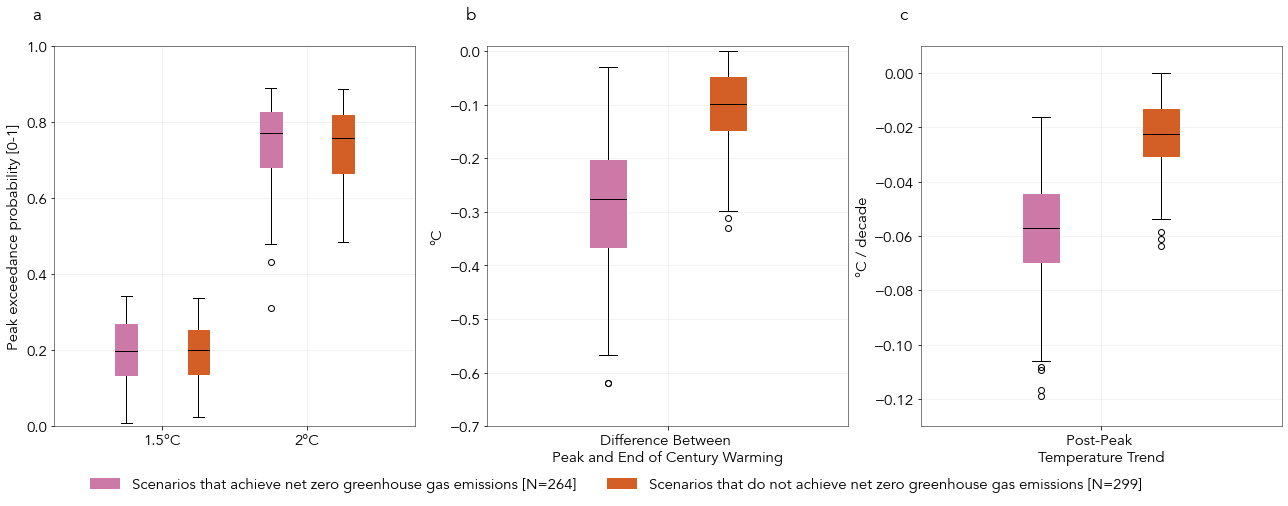

In [22]:
fig, ax = plt.subplots(1,3, figsize=(22,7))

# Panel 1 
for i, var in enumerate(panel_1_variables):
    p1 = ax[0].boxplot(
        panel_1_net_zero[var], 
        positions=[i], 
        patch_artist=True
    )
    p2 = ax[0].boxplot(
        panel_1_no_net_zero[var], 
        positions=[i+0.5], 
        patch_artist=True
    )
    plt.setp(p1['boxes'], color="#cc79a7")
    plt.setp(p1['medians'], color="black")
    plt.setp(p2['boxes'], color="#d35f27")
    plt.setp(p2['medians'], color="black")

ax[0].set_xticks([0.25, 1.25])
ax[0].set_xticklabels(
    [
        "1.5°C",
        "2°C"
    ]
)
ax[0].set_ylabel("Peak exceedance probability [0-1]")
ax[0].set_ylim(0,1)

# Panel 2
for i, var in enumerate(panel_2_variables):
    p1 = ax[i+1].boxplot(
        panel_2_net_zero[var], 
        positions=[i], 
        patch_artist=True
    )
    p2 = ax[i+1].boxplot(
        panel_2_no_net_zero[var], 
        positions=[i+0.5], 
        patch_artist=True
    )
    plt.setp(p1['boxes'], color="#cc79a7")
    plt.setp(p1['medians'], color="black")
    plt.setp(p2['boxes'], color="#d35f27")
    plt.setp(p2['medians'], color="black")

ax[1].set_xticks([0.25])
ax[1].set_xticklabels(["Difference Between \nPeak and End of Century Warming"])
ax[1].set_ylabel("°C")
ax[1].set_ylim(-0.7, 0.01,)

ax[2].set_xticks([1.25])
ax[2].set_xticklabels(["Post-Peak \nTemperature Trend"])
ax[2].set_ylabel("°C / decade")
ax[2].set_ylim(-0.13, 0.01)

n_net_zero = len(panel_2_net_zero[var])
n_no_net_zero = len(panel_2_no_net_zero[var])

# Legend
legend_handles = [ 
    Patch(facecolor="#cc79a7", label="Scenarios that achieve net zero greenhouse gas emissions [N={}]".format(n_net_zero)), 
    Patch(facecolor="#d35f27", label="Scenarios that do not achieve net zero greenhouse gas emissions [N={}]".format(n_no_net_zero))
]
ax[1].legend(
    handles=legend_handles,
    bbox_to_anchor= (1.85, -0.1),
    ncol=2
)


# Annotations
for n,a in enumerate(ax):
    a.text(
        -0.06, 1.07, 
        string.ascii_lowercase[n], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )
    a.set_xlabel("")

# Figure 3

First, we want to assign the years of net zero emissions (both CO2 and GHG)

In [23]:
def _cross_threshold(x):
    y = pyam.cross_threshold(x, threshold=0.1)
    # set threshold slightly above 0 to catch convergence to 0
    return y[0] if len(y) else 2101 #I adapt this to 2101 to catch the >2100 explicitly

def calculate_netzero(_df):
    return _df.apply(_cross_threshold, raw=False, axis=1)

In [24]:
co2 = (
    df_ar6
    .filter(variable="AR6 climate diagnostics|Infilled|Emissions|CO2")
    .timeseries()
)

In [25]:
df_ar6.set_meta(
    calculate_netzero(co2),
    "netzero|CO2"
)

In [26]:
kyotoghg = (
    df_ar6
    .filter(variable="AR6 climate diagnostics|Infilled|Emissions|Kyoto Gases (AR6-GWP100)")
    .timeseries()
)

In [27]:
df_ar6.set_meta(
    calculate_netzero(kyotoghg),
    "netzero|kyotoghg"
)

Next, we proceed to assign 2030 emission levels.

In [28]:
df_ar6.set_meta_from_data(
    name="Emissions|KyotoGHG|2030", 
    variable="AR6 climate diagnostics|Infilled|Emissions|Kyoto Gases (AR6-GWP100)", 
    year=2030 
)

In [29]:
df_ar6.set_meta_from_data(
    name="Emissions|CO2|2030", 
    variable="AR6 climate diagnostics|Infilled|Emissions|CO2", 
    year=2030 
)

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


Text(0, 0.5, 'Gt CO$_2$e')

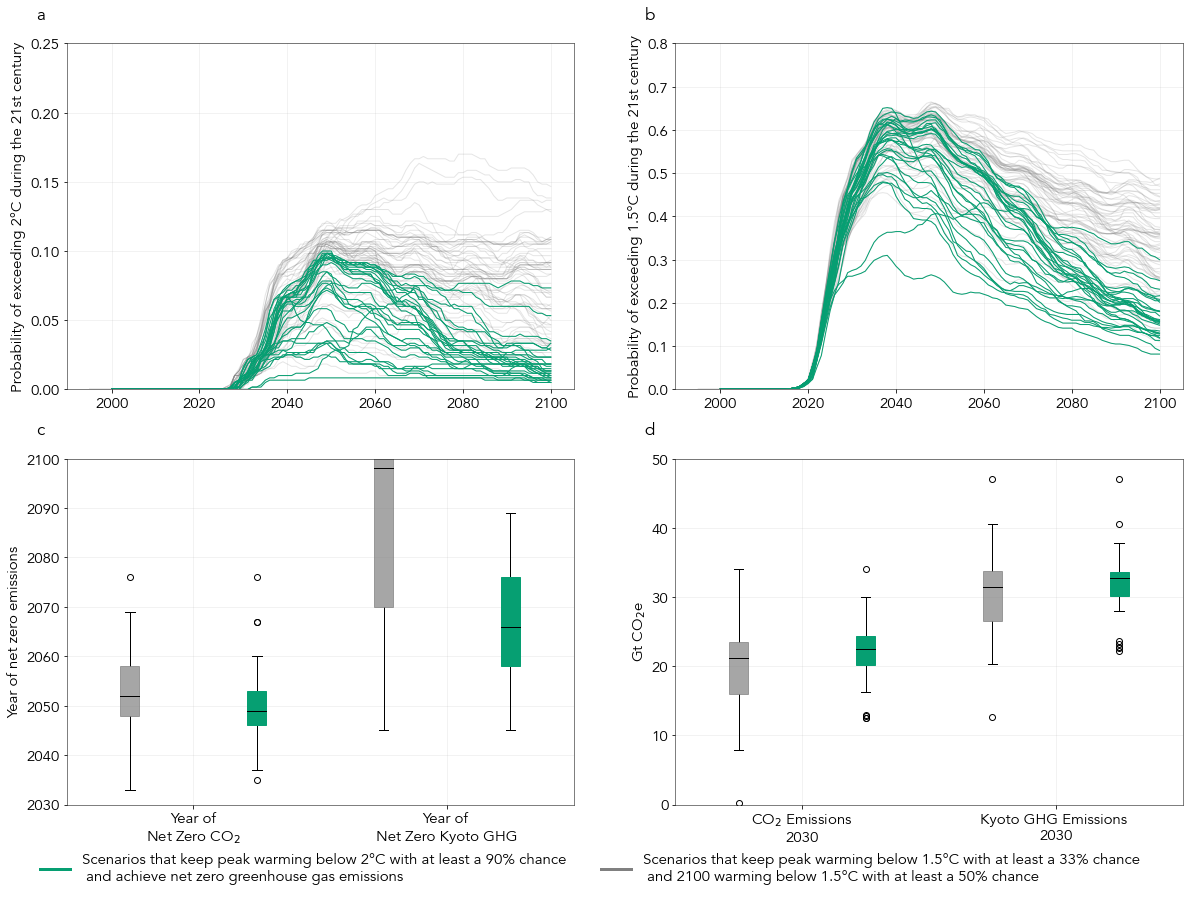

In [30]:
fig, ax = plt.subplots(2,2,figsize = (20,14))
#############
#PANEL 1
#############
df_ar6.filter(
    Category="C1",
    variable="AR6 climate diagnostics|Exceedance Probability 2.0C|MAGICCv7.5.3"
).plot(
    ax=ax[0,0],
    color="grey",
    alpha=0.2
)
df_ar6.filter(
    category_new="PA (Art 2 and 4)",
    variable = "AR6 climate diagnostics|Exceedance Probability 2.0C|MAGICCv7.5.3"
).plot(
    ax = ax[0,0],
    color = "#069f72",
)

ax[0,0].set_title("")
ax[0,0].set_ylim(0,0.25)
ax[0,0].set_ylabel("Probability of exceeding 2°C during the 21st century")

#############
#PANEL 2
#############
df_ar6.filter(
    Category="C1",
    variable="AR6 climate diagnostics|Exceedance Probability 1.5C|MAGICCv7.5.3"
).plot(
    ax=ax[0,1],
    color="grey",
    alpha=0.2
)
df_ar6.filter(
    category_new="PA (Art 2 and 4)",
    variable="AR6 climate diagnostics|Exceedance Probability 1.5C|MAGICCv7.5.3"
).plot(
    ax=ax[0,1],
    color="#069f72",
)

ax[0,1].set_title("")
ax[0,1].set_ylim(0,0.8)
ax[0,1].set_ylabel("Probability of exceeding 1.5°C during the 21st century")

#############
#PANEL 3
#############
lo_os = df_ar6.filter(Category="C1").meta
art2 = df_ar6.filter(Category="C1", category_new="PA (Art 2 and 4)").meta


p1 = ax[1,0].boxplot(
    lo_os["netzero|CO2"], 
    positions=[0], 
    patch_artist=True
)
p2 = ax[1,0].boxplot(
    art2["netzero|CO2"], 
    positions=[1], 
    patch_artist=True
)

p3 = ax[1,0].boxplot(
    lo_os["netzero|kyotoghg"].dropna(), 
    positions=[2], 
    patch_artist=True
)
p4 = ax[1,0].boxplot(
    art2["netzero|kyotoghg"], 
    positions=[3],
    patch_artist=True
)


#############
#PANEL 4
#############
p5 = ax[1,1].boxplot(
    (lo_os["Emissions|CO2|2030"]/1e3).dropna(), 
    positions=[0], 
    patch_artist=True
)
p6 = ax[1,1].boxplot(
    (art2["Emissions|CO2|2030"]/1e3).dropna(), 
    positions=[1],
    patch_artist=True
)

p7 = ax[1,1].boxplot(
    (lo_os["Emissions|KyotoGHG|2030"]/1e3).dropna(), 
    positions=[2], 
    patch_artist=True
)
p8 = ax[1,1].boxplot(
    (art2["Emissions|KyotoGHG|2030"]/1e3).dropna(), 
    positions=[3],
    patch_artist=True,
)


for p in [p2, p4, p6, p8]:
    plt.setp(p['boxes'], color="#069f72")
    plt.setp(p['medians'], color='black')  

for p in [p1, p3, p5, p7]:
    plt.setp(p['boxes'], color="grey", alpha=0.7)
    plt.setp(p['medians'], color='black')  

ax[1,0].set_ylim(2030,2100)
ax[1,0].set_xticks([0.5, 2.5])
ax[1,0].set_xticklabels(
    [ 
        "Year of\nNet Zero CO$_2$", 
        "Year of \nNet Zero Kyoto GHG"
    ]
)

ax[1,1].set_ylim(0, 50)
ax[1,1].set_xticks([0.5, 2.5])
ax[1,1].set_xticklabels(
    [ 
        "CO$_2$ Emissions\n2030", 
        "Kyoto GHG Emissions \n2030"
    ]
)

####################
#Additional elements
####################
for n,a in enumerate(ax[0]):
    a.text(
        -0.06, 1.07, 
        string.ascii_lowercase[n], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )
    a.set_xlabel("")

for n,a in enumerate(ax[1]):
    a.text(
        -0.06, 1.07, 
        string.ascii_lowercase[n+2], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )
    a.set_xlabel("")

# Add custom legend 
# Custom legend 
legend_elements = [ 
    Line2D([0], [0], color='#069f72', lw=3, label="Scenarios that keep peak warming below 2°C with at least a 90% chance \n and achieve net zero greenhouse gas emissions"), 
    Line2D([0], [0], color='grey',lw = 3, label="Scenarios that keep peak warming below 1.5°C with at least a 33% chance \n and 2100 warming below 1.5°C with at least a 50% chance")
]

ax[1,0].legend(
    handles=legend_elements,
    bbox_to_anchor=(2.15, -0.1),
    ncol=2
)
ax[1,0].set_ylabel("Year of net zero emissions")
ax[1,1].set_ylabel("Gt CO$_2$e")

In [31]:
fig.savefig(
    Path("figures/SI Figure 3.png"),
    dpi = 1000
)

# Statistics for text

In [32]:
cols_to_summarise = [
    "netzero|kyotoghg", 
    "netzero|CO2",
    "Emissions|CO2|2030",
    "Emissions|KyotoGHG|2030",
]

In [33]:
analysis_data = df_ar6.filter(
    Category = ["C1"]
).meta

In [34]:
analysis_data.groupby(
    "Category"
)[cols_to_summarise[0:2]].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

netzero|kyotoghg                                                  \
                    count         mean        std     min     10%     25%   
Category                                                                    
C1                   97.0  2085.237113  17.923317  2045.0  2058.0  2070.0   

                                         netzero|CO2                          \
             50%     75%     90%     max       count         mean        std   
Category                                                                       
C1        2098.0  2101.0  2101.0  2101.0        97.0  2053.958763  11.708186   

                                                                  
             min     10%     25%     50%     75%     90%     max  
Category                                                          
C1        2033.0  2044.0  2048.0  2052.0  2058.0  2067.0  2101.0

In [35]:
analysis_data.groupby(
    "category_new"
)[cols_to_summarise[0:2]].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

netzero|kyotoghg                                          \
                            count         mean        std     min     10%   
category_new                                                                
Not PA                       68.0  2093.029412  13.728683  2056.0  2074.4   
PA (Art 2 and 4)             29.0  2066.965517  12.537039  2045.0  2051.0   

                                                          netzero|CO2  \
                      25%     50%     75%     90%     max       count   
category_new                                                            
Not PA            2084.75  2101.0  2101.0  2101.0  2101.0        68.0   
PA (Art 2 and 4)  2058.00  2066.0  2076.0  2085.6  2089.0        29.0   

                                                                          \
                         mean        std     min     10%     25%     50%   
category_new                                                               
Not PA            2055.514706  12.436697  2033.0  2044.7  2050.0  2053.0   
PA (Art 2 and 4)  2050.310345   8.956655  2035.0  2039.4  2046.0  2049.0   

                                          
                     75%     90%     max  
category_new                              
Not PA            2059.0  2067.0  2101.0  
PA (Art 2 and 4)  2053.0  2061.4  2076.0

# Year of peak exceedance for SI

In [36]:
def year_of_peak_exceedance(df):
    return df[df == df.max()].index[0]

In [37]:
exceedance_1p5 = plot_figure_2.filter(
    variable = "AR6 climate diagnostics|Exceedance Probability 1.5C|MAGICCv7.5.3"
).timeseries()

In [38]:
exceedance_1p5.apply(year_of_peak_exceedance, axis=1).describe()

count     563.000000
mean     2050.207815
std        10.321236
min      2036.000000
25%      2048.000000
50%      2048.000000
75%      2049.000000
max      2100.000000
dtype: float64

In [39]:
exceedance_2p0 = plot_figure_2.filter(
    variable = "AR6 climate diagnostics|Exceedance Probability 2.0C|MAGICCv7.5.3"
).timeseries()

In [40]:
exceedance_2p0.apply(year_of_peak_exceedance, axis=1).describe()

count     563.000000
mean     2064.058615
std        16.779874
min      2037.000000
25%      2049.000000
50%      2059.000000
75%      2070.000000
max      2100.000000
dtype: float64

# Table 3
This is the table in the discussion section.

In [41]:
plot_figure_2.meta.columns

Index(['Category', 'Category_name', 'Category_subset', 'Subset_Ch4',
       'Category_Vetting_historical', 'IMP_marker',
       'Literature Reference (if applicable)', 'Policy_category',
       'Policy_category_name', 'Project_study', 'CO2 emissions 2030 Gt CO2/yr',
       'CO2 emissions 2050 Gt CO2/yr', 'CO2 emissions 2100 Gt CO2/yr', 'COVID',
       'GDP|MER-per-capita-in-2100', 'GDP|MER-per-capita-in-2100_bin',
       'GHG emissions 2030 Gt CO2-equiv/yr (Harmonized-Infilled)',
       'GHG emissions 2050 Gt CO2-equiv/yr (Harmonized-Infilled)',
       'GHG emissions 2100 Gt CO2-equiv/yr (Harmonized-Infilled)',
       'GHG emissions reductions 2019-2030 % modelled Harmonized-Infilled',
       'GHG emissions reductions 2019-2050 % modelled Harmonized-Infilled',
       'CO2 emissions reductions 2019-2030 % modelled Harmonized-Infilled',
       'CO2 emissions reductions 2019-2040 % modelled Harmonized-Infilled',
       'CO2 emissions reductions 2019-2050 % modelled Harmonized-Infilled',
 

In [42]:
t3_data = plot_figure_2.meta

In [43]:
t3_data = t3_data[t3_data.category_new == "PA (Art 2 and 4)"]

In [44]:
t3_data["subcategory_c1"] = "1.5C low overshoot"
t3_data["subcategory_c1"][
    (t3_data["peak_exceedance_1p5"]<=0.5)
] = "Below 1.5C"

/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_20310/3891267692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t3_data["subcategory_c1"] = "1.5C low overshoot"
/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_20310/3891267692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t3_data["subcategory_c1"][
/opt/anaconda3/envs/scenario_categorisation/lib/python3.8/site-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

In [45]:
columns_for_table_3 = [
    'GHG emissions 2030 Gt CO2-equiv/yr (Harmonized-Infilled)',
    "Year of netzero CO2 emissions (Harm-Infilled) table" ,
    "netzero|kyotoghg",
    'peak_warming',
    '2100_warming'
    
]

Joint distribution.

In [46]:
t3_data[columns_for_table_3].describe().T.round(2)

count     mean    std  \
GHG emissions 2030 Gt CO2-equiv/yr (Harmonized-...   29.0    31.86   5.45   
Year of netzero CO2 emissions (Harm-Infilled) t...   29.0  2050.31   8.96   
netzero|kyotoghg                                     29.0  2066.97  12.54   
peak_warming                                         29.0     1.55   0.05   
2100_warming                                         29.0     1.18   0.07   

                                                        min      25%      50%  \
GHG emissions 2030 Gt CO2-equiv/yr (Harmonized-...    22.14    30.19    32.74   
Year of netzero CO2 emissions (Harm-Infilled) t...  2035.00  2046.00  2049.00   
netzero|kyotoghg                                    2045.00  2058.00  2066.00   
peak_warming                                           1.40     1.53     1.55   
2100_warming                                           1.02     1.13     1.18   

                                                        75%      max  
GHG emissions 2030 Gt CO2-equiv/yr (Harmonized-...    33.62    47.12  
Year of netzero CO2 emissions (Harm-Infilled) t...  2053.00  2076.00  
netzero|kyotoghg                                    2076.00  2089.00  
peak_warming                                           1.58     1.60  
2100_warming                                           1.23     1.34

In [47]:
t3_data.groupby("subcategory_c1")[columns_for_table_3].describe().T.round(2)

subcategory_c1                                            1.5C low overshoot  \
GHG emissions 2030 Gt CO2-equiv/yr (Harmonized-... count               24.00   
                                                   mean                33.52   
                                                   std                  4.27   
                                                   min                 23.57   
                                                   25%                 32.03   
                                                   50%                 32.97   
                                                   75%                 34.21   
                                                   max                 47.12   
Year of netzero CO2 emissions (Harm-Infilled) t... count               24.00   
                                                   mean              2049.83   
                                                   std                  6.77   
                                                   min               2037.00   
                                                   25%               2046.75   
                                                   50%               2049.00   
                                                   75%               2053.00   
                                                   max               2067.00   
netzero|kyotoghg                                   count               24.00   
                                                   mean              2065.62   
                                                   std                 12.01   
                                                   min               2045.00   
                                                   25%               2057.75   
                                                   50%               2065.00   
                                                   75%               2073.50   
                                                   max               2089.00   
peak_warming                                       count               24.00   
                                                   mean                 1.56   
                                                   std                  0.02   
                                                   min                  1.50   
                                                   25%                  1.55   
                                                   50%                  1.57   
                                                   75%                  1.58   
                                                   max                  1.60   
2100_warming                                       count               24.00   
                                                   mean                 1.18   
                                                   std                  0.06   
                                                   min                  1.06   
                                                   25%                  1.13   
                                                   50%                  1.18   
                                                   75%                  1.23   
                                                   max                  1.27   

subcategory_c1                                            Below 1.5C  
GHG emissions 2030 Gt CO2-equiv/yr (Harmonized-... count        5.00  
                                                   mean        23.92  
                                                   std          2.77  
                                                   min         22.14  
                                                   25%         22.67  
                                                   50%         22.76  
                                                   75%         23.19  
                                                   max         28.84  
Year of netzero CO2 emissions (Harm-Infilled) t... count        5.00  
         

# Comparison of peak exceedance to SR1.5

In [48]:
df_sr15 = pyam.read_iiasa(
    "iamc15",
    model = "*",
    scenario = "*",
    variable = "AR5 climate diagnostics|Temperature|*",
    meta = ["category"]   
)

pyam.iiasa - INFO: You are connected to the IXSE_SR15 scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ene.iiasa.ac.at/iamc-1.5c-explorer/#/about
pyam.iiasa - INFO: You are connected as an anonymous user


In [49]:
df_sr15_low_os = df_sr15.filter(
    category = ["Below 1.5C", "1.5C low overshoot"]
)

In [50]:
exceedance_1p5_sr15 = df_sr15_low_os.filter(
    variable = "AR5 climate diagnostics|Temperature|Exceedance Probability|1.5 °C|MAGICC6"
).timeseries()

In [51]:
exceedance_2p0_sr15 = df_sr15_low_os.filter(
    variable = "AR5 climate diagnostics|Temperature|Exceedance Probability|2.0 °C|MAGICC6"
).timeseries()

In [52]:
df_sr15_low_os.set_meta(
    exceedance_1p5_sr15.apply(
        year_of_peak_exceedance,
        axis = 1
    ),
    name = "peak_year_1p5"
)

In [53]:
df_sr15_low_os.set_meta(
    exceedance_2p0_sr15.apply(
        year_of_peak_exceedance,
        axis = 1
    ),
    name = "peak_year_2p0"
)

We also want to add the smoothed trajectories for the AR6 data.

In [54]:
plot_figure_2_smoothed = df_ar6.filter(
    Category_rolling_mean=["C1", "C2", "C3"],
    variable =[
        "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile",
        "AR6 climate diagnostics|Exceedance Probability 1.5C|MAGICCv7.5.3|Rolling Mean",
        "AR6 climate diagnostics|Exceedance Probability 2.0C|MAGICCv7.5.3|Rolling Mean"
    ]
)

In [55]:
exceedance_1p5_smoothed = plot_figure_2_smoothed.filter(
    variable = "AR6 climate diagnostics|Exceedance Probability 1.5C|MAGICCv7.5.3|Rolling Mean"
).timeseries()

In [56]:
exceedance_2p0_smoothed = plot_figure_2_smoothed.filter(
    variable = "AR6 climate diagnostics|Exceedance Probability 2.0C|MAGICCv7.5.3|Rolling Mean"
).timeseries()

In [57]:
plot_figure_2.set_meta(
    exceedance_1p5.apply(
        year_of_peak_exceedance,
        axis = 1
    ),
    name = "peak_year_1p5"
)

In [58]:
plot_figure_2.set_meta(
    exceedance_1p5_smoothed.apply(
        year_of_peak_exceedance,
        axis = 1
    ),
    name = "peak_year_1p5_smoothed"
)

In [59]:
plot_figure_2.set_meta(
    exceedance_2p0.apply(
        year_of_peak_exceedance,
        axis = 1
    ),
    name = "peak_year_2p0"
)

In [60]:
plot_figure_2.set_meta(
    exceedance_2p0_smoothed.apply(
        year_of_peak_exceedance,
        axis = 1
    ),
    name = "peak_year_2p0_smoothed"
)

In [61]:
plot_figure_2_c1 = plot_figure_2.filter(
    Category = "C1"
).meta[["peak_year_1p5", "peak_year_2p0", "peak_year_1p5_smoothed", "peak_year_2p0_smoothed"]]

In [62]:
plot_data_sr15 = df_sr15_low_os.meta[["peak_year_1p5", "peak_year_2p0"]]

# Calculate differences for a histogram

In [63]:
plot_figure_2_c1["diff"] = plot_figure_2_c1["peak_year_2p0"] - plot_figure_2_c1["peak_year_1p5"]
plot_figure_2_c1["diff_smooth"] = plot_figure_2_c1["peak_year_2p0_smoothed"] - plot_figure_2_c1["peak_year_1p5_smoothed"]

/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_20310/2201511743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_figure_2_c1["diff"] = plot_figure_2_c1["peak_year_2p0"] - plot_figure_2_c1["peak_year_1p5"]
/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_20310/2201511743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_figure_2_c1["diff_smooth"] = plot_figure_2_c1["peak_year_2p0_smoothed"] - plot_figure_2_c1["peak_year_1p5_smoothed"]


In [64]:
plot_data_sr15["diff"] = plot_data_sr15["peak_year_2p0"] - plot_data_sr15["peak_year_1p5"]

/var/folders/yw/qzffs_jd1l3b0w2tk4cdqxj00000gn/T/ipykernel_20310/2282295443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data_sr15["diff"] = plot_data_sr15["peak_year_2p0"] - plot_data_sr15["peak_year_1p5"]


In [65]:
def plotting_helper(df, ax):
    med = df.median()
    p25 = df.quantile(q=0.25)
    p75 = df.quantile(q=0.75)
    ax.axvline(med, color = "black", linestyle="dashed")
    ax.axvspan(p25, p75, color = "black", alpha=0.2)

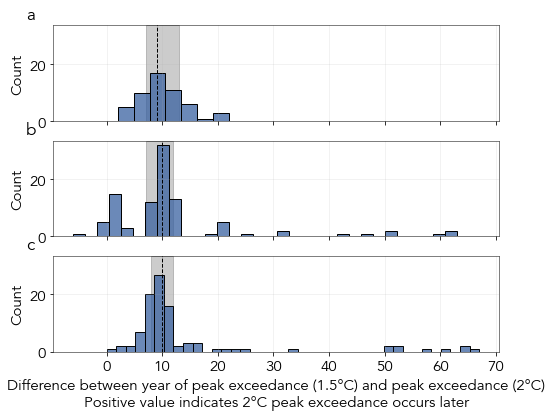

In [66]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True)

plotting_helper(plot_data_sr15["diff"], ax[0])
sns.histplot(
    x = plot_data_sr15["diff"],
    ax=ax[0]
)

plotting_helper(plot_figure_2_c1["diff"], ax[1])
sns.histplot(
    x = plot_figure_2_c1["diff"],
    ax=ax[1]
)

plotting_helper(plot_figure_2_c1["diff_smooth"], ax[2])
sns.histplot(
    x = plot_figure_2_c1["diff_smooth"],
    ax=ax[2]
)

ax[2].set_xlabel("Difference between year of peak exceedance (1.5°C) and peak exceedance (2°C)\nPositive value indicates 2°C peak exceedance occurs later")

# Add annotations
for n,a in enumerate(ax):
    a.text(
        -0.06, 1.07, 
        string.ascii_lowercase[n], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )

In [67]:
fig.savefig(
    Path("figures/SI Figure Diff.png")
)